In [1]:
import pandas
import os
datadir = 'd:\\plant-pathology-2021-fgvc8\\'
csvfile = os.path.join(datadir, 'train.csv')
dataframes = pandas.read_csv(csvfile)
print("File at {} contains {} rows".format(csvfile, len(dataframes)))

File at d:\plant-pathology-2021-fgvc8\train.csv contains 18632 rows


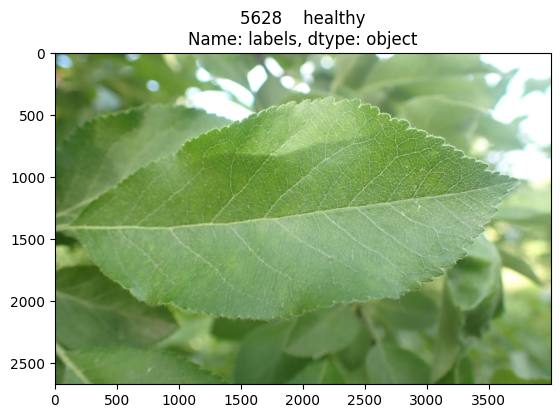

In [2]:
import matplotlib.pyplot
import skimage.io
sample = dataframes.sample()
imagefilename = sample['image'].values[0]
label = sample['labels']
imagefilepath = os.path.join(datadir + 'train_images/', imagefilename)
image = skimage.io.imread(imagefilepath)
matplotlib.pyplot.imshow(image)
matplotlib.pyplot.title(label)
matplotlib.pyplot.show()

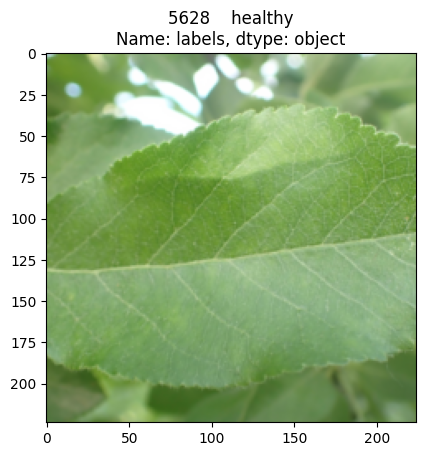

In [3]:
# Later I will be using a more robust approach for doing transformation but for now let me show
# how to do image resizing|cropping in order to have images that we can use for a 1st image classifier model
# I am using scikit-image python package for manipulating images but I could be using other ones such as
# opencv or writing my own image reader
import skimage.transform
import numpy
def imageResizingAndRandomCropping(imagedata, resizesize, cropsize):
    h, w = imagedata.shape[:2]
    if isinstance(resizesize, int):
        if h > w:
            resizeh, resizew = resizesize * h / w, resizesize
        else:
            resizeh, resizew = resizesize, resizesize * w / h
    else:
        resizeh, resizew = resizesize
    resizedimage = skimage.transform.resize(imagedata, (resizeh, resizew))
    croph, cropw = (cropsize, cropsize)
    top = numpy.random.randint(0, resizeh - croph)
    left = numpy.random.randint(0, resizew - cropw)
    croppedimage = resizedimage[top:top + croph, left:left + cropw]
    return croppedimage

transformedimage = imageResizingAndRandomCropping(image, 256, 224)
matplotlib.pyplot.imshow(transformedimage)
matplotlib.pyplot.title(label)
matplotlib.pyplot.show()

In [4]:
# Another thing to check is how many labels are in the dataset?
def consoleLogLabelsInformation(dataframes):
    uniquelabelsinformation = {}
    labelsinformation = {}
    for _, rowdata in dataframes.iterrows():
        labels = rowdata['labels']
        if labels not in labelsinformation:
            labelsinformation[labels] = 0
        labelsinformation[labels] += 1
        unique_labels = labels.split(' ')
        for label in unique_labels:
            if (label not in uniquelabelsinformation):
                uniquelabelsinformation[label] = 0
            uniquelabelsinformation[label] += 1
    print("{} labels with the following distribution".format(len(labelsinformation)))
    for key,value in labelsinformation.items():
        print("\t{}: {}".format(key, value))
    print("{} unique labels with the following distribution".format(len(uniquelabelsinformation)))
    for key,value in uniquelabelsinformation.items():
        print("\t{}: {}".format(key, value))
        
consoleLogLabelsInformation(dataframes)

12 labels with the following distribution
	healthy: 4624
	scab frog_eye_leaf_spot complex: 200
	scab: 4826
	complex: 1602
	rust: 1860
	frog_eye_leaf_spot: 3181
	powdery_mildew: 1184
	scab frog_eye_leaf_spot: 686
	frog_eye_leaf_spot complex: 165
	rust frog_eye_leaf_spot: 120
	powdery_mildew complex: 87
	rust complex: 97
6 unique labels with the following distribution
	healthy: 4624
	scab: 5712
	frog_eye_leaf_spot: 4352
	complex: 2151
	rust: 2077
	powdery_mildew: 1271


In [5]:
import time
time_1 = time.time()
import torch
time_2 = time.time()
print("You are using PyTorch version ", torch.__version__, " and took to load ", time_2 - time_1, " seconds")

You are using PyTorch version  2.4.1+cpu  and took to load  3.0890395641326904  seconds


In [6]:
# ML frameworks have a way of loading data directly if its data directory has certain structure, for now
# let me show you how to do it by 'hand'
import torchvision.transforms
import torch.utils.data
import torch.utils
import skimage.io
import skimage.transform

class Rescale(object):
    def __init__(self, outputsize):
        assert isinstance(outputsize, (int, tuple))
        self.outputsize = outputsize
    
    def __call__(self, data):
        image = data['image']
        h, w = image.shape[:2]
        if isinstance(self.outputsize, int):
            if h > w:
                newh, neww = self.outputsize * h / w, self.outputsize
            else:
                newh, neww = self.outputsize, self.outputsize * w / h
        else:
            newh, neww = self.outputsize
        newh, neww = int(newh), int(neww)
        transformedimage = skimage.transform.resize(image, (newh, neww))
        return {'image':transformedimage, 'label':data['label']}

class RandomCrop(object):
    def __init__(self, outputsize):
        assert isinstance(outputsize, (int, tuple))
        if isinstance(outputsize, int):
            self.outputsize = (outputsize, outputsize)
        else:
            assert len(outputsize) == 2
            self.outputsize = outputsize

    def __call__(self, data):
        image = data['image']
        h, w = image.shape[:2]
        newh, neww = self.outputsize
        top = numpy.random.randint(0, h - newh)
        left = numpy.random.randint(0, w - neww)
        image = image[top:top + newh, left:left + neww]
        return {'image':image, 'label':data['label']}

class ToTensor(object):
    def __call__(self, data):
        image = data['image']
        image = image.transpose((2, 0, 1))
        return {'image':torch.from_numpy(image).float(), 'label':data['label']}

class LeafDataset(torch.utils.data.Dataset):
    def __init__(self, csvfile:str, rootdirectory:str, imagesfolder:str, transform=None):
        self.csvfile = os.path.join(rootdirectory, csvfile)
        self.imagesdirectory = rootdirectory + imagesfolder
        self.transform = transform
        self.dataframes = pandas.read_csv(self.csvfile)
        self.classes = {}
        self.computeclasses()
        
    def __len__(self):
        return len(self.dataframes)

    def __getitem__(self, index):
        imagefilepath = os.path.join(self.imagesdirectory, self.dataframes.iloc[index].iloc[0])
        imagedata = skimage.io.imread(imagefilepath)
        imagelabel = self.dataframes.iloc[index].iloc[1]
        sample = {'image':imagedata, 'label':self.classes[imagelabel]}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def computeclasses(self):
        labelid = 0
        for _,row in self.dataframes.iterrows():
            if row['labels'] not in self.classes:
                self.classes[row['labels']] = labelid
                labelid += 1

# A trick to avoid the gigantic images is preprocess them and save them
# to disk, this will be in handy in later sections (if not takes forever to train on CPU)
useresizedimages = True
if (useresizedimages):
    transformationtoapply = [ToTensor()]
    imagesfolder = "train_images_resized\\"
else:
    transformationtoapply = [Rescale(256), RandomCrop(224), ToTensor()]
    imagesfolder = "train_images\\"
traindataset = LeafDataset(
    csvfile="train.csv", 
    rootdirectory=datadir,
    imagesfolder=imagesfolder, 
    transform=torchvision.transforms.Compose(transformationtoapply)
)
batchsize = 4
numworkers = 0
trainloader = torch.utils.data.DataLoader(
    traindataset, 
    batch_size=batchsize, 
    shuffle=True, 
    num_workers=numworkers
    )

In [7]:
# Everything seems great but how do we know the data is loaded correctly, let me console out
# the first batch from the trainloader variable
for batchIndex, batchData in enumerate(trainloader):
    inputs, labels = batchData['image'], batchData['label']
    print(inputs.shape)
    print(labels)
    break

torch.Size([4, 3, 224, 224])
tensor([2, 0, 0, 5])


In [8]:
# Now the magic part of ML, creating the neural network model
# For now let's just put the following class
class ImageClassificationNN(torch.nn.Module):
    def __init__(self):
        super(ImageClassificationNN, self).__init__()
        self.convolution1 = torch.nn.Conv2d(3, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.convolution2 = torch.nn.Conv2d(6, 16, 5)
        self.fullyconnected1 = torch.nn.Linear(16 * 53 * 53, 120)
        self.fullyconnected2 = torch.nn.Linear(120, 84)
        self.fullyconnected3 = torch.nn.Linear(84, 12)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.convolution1(x)))
        x = self.pool(torch.nn.functional.relu(self.convolution2(x)))
        x = x.flatten(1)
        x = torch.nn.functional.relu(self.fullyconnected1(x))
        x = torch.nn.functional.relu(self.fullyconnected2(x))
        x = self.fullyconnected3(x)
        return x

neuralnetwork = ImageClassificationNN()
print(neuralnetwork)

ImageClassificationNN(
  (convolution1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convolution2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fullyconnected1): Linear(in_features=44944, out_features=120, bias=True)
  (fullyconnected2): Linear(in_features=120, out_features=84, bias=True)
  (fullyconnected3): Linear(in_features=84, out_features=12, bias=True)
)


In [9]:
# This is the last part, just define the loss function, optimizer, and then start training
# We will not be doing a full training but just show the 1st 10 iterations to check
# the loss being reduced (meaning our network is working)
criterion = torch.nn.CrossEntropyLoss()
learningrate = 0.001
momentum = 0.9
optimizer = torch.optim.SGD(neuralnetwork.parameters(), lr=learningrate, momentum=momentum)
epochs = 1
minibatch = 16
for epoch in range(epochs):
    sampleloss = 0.0
    for batchIndex, batchData in enumerate(trainloader):
        inputs, labels = batchData['image'], batchData['label']
        optimizer.zero_grad()
        outputs = neuralnetwork(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        sampleloss += loss.item()
        if (batchIndex % minibatch == (minibatch - 1)):
            print("Loss at {} of {}: {}".format(batchIndex, len(trainloader), sampleloss / minibatch))
            sampleloss = 0.0
        if (batchIndex > 639):
            break

Loss at 15 of 4658: 7.195335671305656
Loss at 31 of 4658: 2.4248854368925095
Loss at 47 of 4658: 2.3918884247541428
Loss at 63 of 4658: 2.389579027891159
Loss at 79 of 4658: 2.3199934661388397
Loss at 95 of 4658: 2.309065133333206
Loss at 111 of 4658: 2.3014302998781204
Loss at 127 of 4658: 2.268522560596466
Loss at 143 of 4658: 2.2369155287742615
Loss at 159 of 4658: 2.8378883749246597
Loss at 175 of 4658: 2.241526998579502
Loss at 191 of 4658: 2.2164118736982346
Loss at 207 of 4658: 2.2749288007616997
Loss at 223 of 4658: 2.290696457028389
Loss at 239 of 4658: 2.119600735604763
Loss at 255 of 4658: 2.1989795118570328
Loss at 271 of 4658: 2.236158326268196
Loss at 287 of 4658: 2.2720794454216957
Loss at 303 of 4658: 2.225414752960205
Loss at 319 of 4658: 2.0142563208937645
Loss at 335 of 4658: 1.9966055825352669
Loss at 351 of 4658: 2.1601440981030464
Loss at 367 of 4658: 2.2119393423199654
Loss at 383 of 4658: 2.127044267952442
Loss at 399 of 4658: 2.132223293185234
Loss at 415 of 46